## Pison Data Science Technical Assessment
### Author: Dante J Smith

## Library and Data Imports

In [1]:
# Import Basic Libraries
import os                          # os
import numpy as np                 # Numpy
import pandas as pd                # PANDAS
from itertools import permutations # Permutations
import matplotlib.pyplot as plt    # matplotlib

# Machine Learning
from sklearn.decomposition import PCA            # Principal Components Analysis
from sklearn.preprocessing import StandardScaler # StandardScalar
from sklearn.cluster import KMeans               # K-Means

# Dynamic Time Warping
from dtw import *

# Animations
from matplotlib import rc
from matplotlib.animation import FuncAnimation # matplotlib animation
from IPython.display import HTML               # Jupyter Notebook animation

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



In [2]:
# Define features columns
colNames = ['ts', 'ch0r', 'ch1r', 'ch0hp', 'ch1hp', 'qx', 'qy', 'qz', 'qw',
           'gx', 'gy', 'gz', 'ax', 'ay', 'az', 'bL', 'rep']

# Define Body position labels
bodyLabels = {0: 'standing #1', 1: 'standing #2', 2: 'walking', 3: 'walking fast', 4: 'running'}

# Set location of data folder
dataFolder = r'C:\Users\dante\Documents\Data\Pison'

# Load csv data and save it to a dataframe pisonDataFrame (pDF)
pDF =  pd.read_csv(os.path.join(dataFolder, 'pison_data_interview.csv'), header = None, names = colNames)

# Quick data summary and investigate top 5 rows
print(f'Working with {len(pDF)} samples')
pDF.head() 

Working with 14981 samples


,ts,ch0r,ch1r,ch0hp,ch1hp,qx,qy,qz,qw,gx,gy,gz,ax,ay,az,bL,rep
0,1514824.503,12535249,12566283,-11889,17295,0.32196,-0.596619,-0.621826,0.392090,-1.342870,1.063105,0.503576,-0.660156,-10.003906,1.21875,0,1
1,1514827.496,12536264,12559246,-2063,13384,0.32196,-0.596741,-0.621826,0.392029,-1.510729,1.175011,0.000000,-0.660156,-10.003906,1.21875,0,1
2,1514830.493,12538584,12565279,2757,16008,0.32196,-0.596741,-0.621765,0.391968,-1.230964,1.175011,-0.279765,-0.660156,-10.003906,1.21875,0,1
3,1514833.500,12546745,12567024,7504,5644,0.32196,-0.596741,-0.621765,0.391968,-1.230964,1.175011,-0.279765,-0.660156,-10.003906,1.21875,0,1
4,1514836.498,12537375,12545467,-3855,-15893,0.32196,-0.596802,-0.621765,0.391907,-1.063105,0.839294,-0.727388,-0.660156,-10.003906,1.21875,0,1


## Data Inspection

In [3]:
# Do some quick testing for the number of repetitions.
# It would seem that there are three repetitions for each body movement
for i in range(0, len(bodyLabels)):
    numreps = pDF.loc[pDF['bL'] == i, 'rep'].unique().max()
    print(f'{numreps} reps for body movement {i}')

3 reps for body movement 0
3 reps for body movement 1
3 reps for body movement 2
3 reps for body movement 3
3 reps for body movement 4


In [4]:
# Identify the combinations of body movement labels and reptitions to be
# considered when comparing time-series sensor data
allbL   = [0, 1, 2, 3, 4]     # All body movement labels
allReps = [1, 2, 3]           # All repetition counts
allbLRep = [[i, j] for i in allbL 
                   for j in allReps] # All combinations of bL and reps. Should be 15 unique combinations.

# Sensor names to be used in Clustering. 
# Ch0/Ch1 raw, Ch0/Ch1 HighPassed, gyroscope (x,y,z), accelerometer (x,y,z)
sensorN = ['ch0r', 'ch1r', 'ch0hp', 'ch1hp', 'gx', 'gy', 'gz', 'ax', 'ay', 'az']

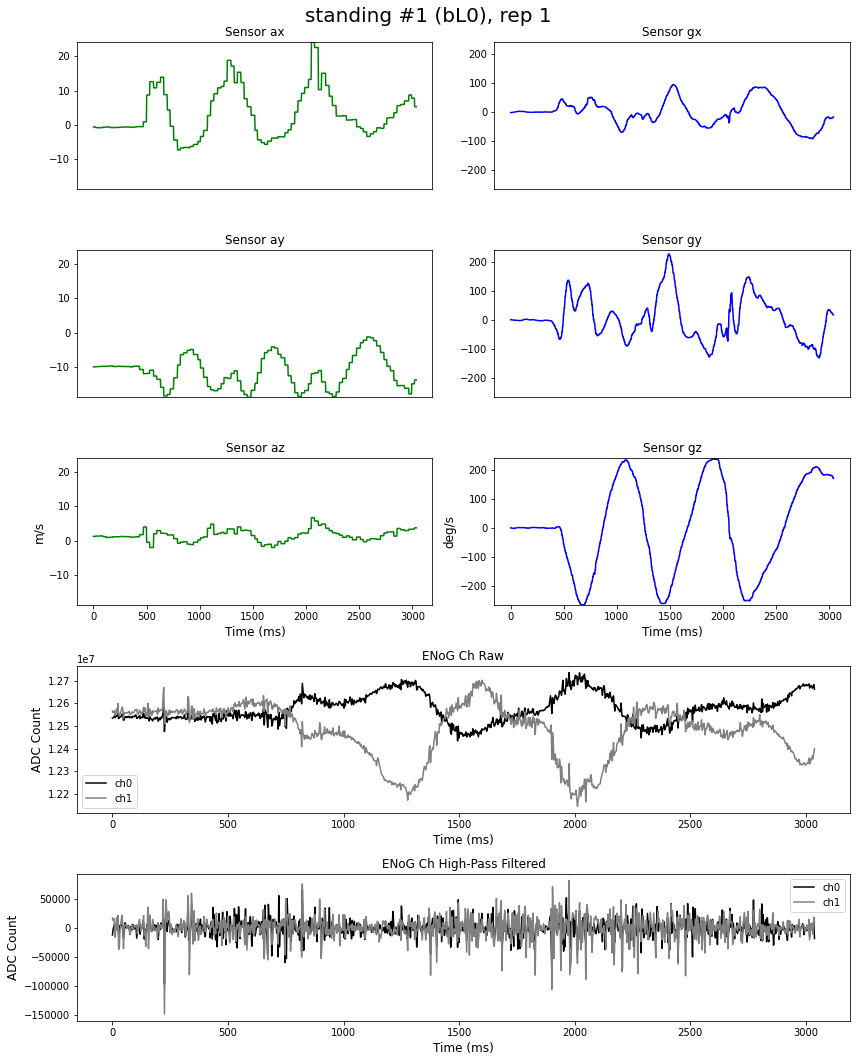

In [5]:
# Generate some visualization with repetition across Accelerometers and Gyroscopes
fig_dir = r'C:/Users/dante/Documents/GitHub/pison-tech-assess/FeaturePlots'

# Create sets of sensors to plot over
sensSet = [['ax', 'ay', 'az'], ['gx', 'gy', 'gz']]
unitLabel = ['m/s', 'deg/s']
colors = ['green', 'blue']

for bLRepCombo in allbLRep:
    bL  = bLRepCombo[0]
    rep = bLRepCombo[1]

    # Take a portion of the data
    pDFSet = pDF.loc[(pDF['bL'] == bL) & (pDF['rep'] == rep)]

    # Create matplotlib objects
    fig = plt.figure(facecolor = 'white', figsize=(12, 15))
    fig.suptitle(f'{bodyLabels[bL]} (bL{bL}), rep {rep}', fontsize=20)

    # Subtract away the first val so that 'time' starts at 0
    time = pDFSet['ts'] - pDFSet.iloc[0]['ts']

    for x, sSet in enumerate(sensSet):
        # Find sensor min/max
        minVal = pDFSet[sSet].min().min()
        maxVal = pDFSet[sSet].max().max()
        
        for y, sens in enumerate(sSet):
            # Generate subplots for the x,y,z of each sensor
            ax = fig.add_subplot(5, 2, (y*2 + 1 + x))
            ax.plot(time, pDFSet[sens], c = colors[x])
            ax.set_title(f'Sensor {sens}')
            # Set universal y-lim for within sensor subplots
            ax.set_ylim(minVal, maxVal)

            if y !=2:
                # Remove X axis ticks unless its the last row of subplot
                ax.get_xaxis().set_visible(False)
            else:
                # Display X/Y Labels for last row of subplots
                ax.set_xlabel('Time (ms)', fontsize=12)
                ax.set_ylabel(unitLabel[x], fontsize=12)

    # Raw Ch0/Ch1 time-series plots
    axChr = fig.add_subplot(5, 1, 4)
    axChr.plot(time, pDFSet['ch0r'], c = 'black')
    axChr.plot(time, pDFSet['ch1r'], c = 'grey')
    axChr.legend(['ch0', 'ch1'])
    axChr.set_title('ENoG Ch Raw')
    axChr.set_xlabel('Time (ms)', fontsize=12)
    axChr.set_ylabel('ADC Count', fontsize=12) 

    # High-pass filtered Ch0/Ch1 time-series plots
    axChh = fig.add_subplot(5, 1, 5)
    axChh.plot(time, pDFSet['ch0hp'], c = 'black')
    axChh.plot(time, pDFSet['ch1hp'], c = 'grey')
    axChh.legend(['ch0', 'ch1'])
    axChh.set_title('ENoG Ch High-Pass Filtered')
    axChh.set_xlabel('Time (ms)', fontsize=12)
    axChh.set_ylabel('ADC Count', fontsize=12)     

    # Create the pile path
    file_dir = os.path.join(fig_dir, f'BL{bL}rep{rep}.png')
    
    # Saving figures in GitHub repo
    fig.tight_layout()
    fig.savefig(file_dir)
    if (bL > 0) | (rep > 1):
        plt.close(fig) # Sequestering figure show for ease

## Machine Learning and Clustering

In [6]:
# Now performing the Dynamic Time Warping (DTW) of the time-series data present in each sensor ch
# between each permuation of body movements and repeition combinations. There are 15 such
# combinations to try and this will result in a 15x15 confusion matrix for each of the 10 sensors.
# Each 15x15 confustion matrix will be decomposed into an average distance to find 
# general qualities of a body position/rep wrist action that match together. 

# Instantiate the dtw resulting data dictionary
dtwDict = {}

# Iterate over sensors
for sens in sensorN:

    # Create an empty confusion matrix to fill in values for 
    confMat = np.zeros([len(allbLRep), len(allbLRep)])

    # Identify distance of time-series within a sensor type between combinations of any two bL/Rep pairs
    for combo in permutations(allbLRep, 2):
        pDFSet1 = pDF.loc[(pDF['bL'] == combo[0][0]) & (pDF['rep'] == combo[0][1])]
        pDFSet2 = pDF.loc[(pDF['bL'] == combo[1][0]) & (pDF['rep'] == combo[1][1])]
        alignment = dtw(pDFSet1[sens], pDFSet2[sens], keep_internals=True, step_pattern=asymmetric,
                            open_end=True,open_begin=True)
        
        # Set the distances in the confusion matrix
        sqCoordX = (combo[0][0])*3 + combo[0][1] -1
        sqCoordY = (combo[1][0])*3 + combo[1][1] -1
        confMat[sqCoordX, sqCoordY] = alignment.normalizedDistance
        # print(f'Dist between bL{combo[0][0]} rep{combo[0][1]} and bL{combo[1][0]} rep{combo[1][1]} is {alignment.normalizedDistance}')

    # Take the mean across the columns to get a general measure of how distances collate together
    # Stick it the dictionary under the 'sensor' key
    dtwDict[sens] = np.mean(confMat, 1)
    
dtwDF = pd.DataFrame(data = dtwDict, index = [str(x) for x in allbLRep])

In [7]:
# Perform Principal Components Analysis (PCA) to reduce the number of features.
# First remind ourselves of the starting position
print(f'Working with {dtwDF.shape[0]} wrist movements, and {dtwDF.shape[1]} sensor features')

# Standardize the scale of the features
dtw_standardScale = StandardScaler().fit_transform(dtwDF)

# Use PCA to decompile number of features. Test a number of components to achieve >= 90% explained variance.
# Through experimentation, found that 5 principal components explained over 90% of the variance.
numComp = 3
pca = PCA(n_components=numComp)
principalComponents = pca.fit_transform(dtw_standardScale)
expVar = pca.explained_variance_ratio_

print(f'Reducing to {numComp} principal components accounts for {round(100*sum(expVar), 2)}% of variance')

# Set PCA into its own DataFrame
principalDf = pd.DataFrame(data = principalComponents,
                           columns = [f'Principal Component {x+1}' for x in range(0, numComp)],
                           index = dtwDF.index)

Working with 15 wrist movements, and 10 sensor features
Reducing to 3 principal components accounts for 94.35% of variance


[(0, ['[0, 1]', '[1, 1]', '[2, 1]', '[3, 1]']),
 (1, ['[0, 3]', '[1, 3]', '[2, 3]', '[3, 3]']),
 (2, ['[4, 2]']),
 (3, ['[0, 2]', '[1, 2]', '[2, 2]', '[3, 2]']),
 (4, ['[4, 3]']),
 (5, ['[4, 1]'])]

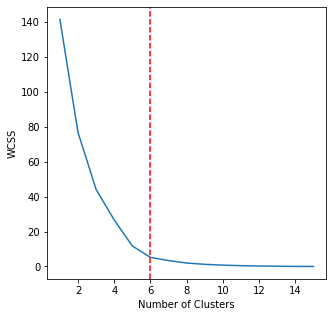

In [8]:
# Use K-means clustering to identify clusters of measured values (DTW distances).
# Not sure how many (unlabeled) classes there should be so lets calculate the
# Within-cluster Sum of Squares (WCSS) obtainted from the intertia_ attribute 
# to track the decrease in observed error of the centroid position as n_cluster increases
clust2Try = range(1, 16) # We know it cant be more than 15 classes
wcss = [] 
for numClust in clust2Try: 
    kmeans = KMeans(n_clusters = numClust, init ='k-means++', max_iter=300, n_init=10,random_state=42)
    kmeans.fit(principalDf) 
    wcss.append(kmeans.inertia_)

# Inspect where the error starts to drop off
fig = plt.figure(figsize = (5,5))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Number of Clusters', fontsize = 10)
ax.set_ylabel('WCSS', fontsize = 10)
plt.plot(list(clust2Try), wcss)

selClusNum = 6
# After Inspection- 6 clusters seems to be appropriate
plt.axvline(selClusNum, linestyle='--', color='r')

# Having selected 6 clusters we now have a model that can be used in future testing and deployment.
# Let us use train our selected model to show which of our wrist movements belong to which classes
kmeansSel = KMeans(n_clusters = selClusNum, init ='k-means++', max_iter=300, n_init=10, random_state=42)
kmeansSel.fit(principalDf) 
classLabel = kmeansSel.labels_ # Extract out the labels of trained data from the fit model

# Reorganize the labeled data by the index names used in our data frame
# Print out the solution for the Take-Home assignment
[(x, list(principalDf.index[classLabel == x])) for x in range(0, selClusNum)]

From the above output we recognize the 6 different classes of wrist movements, and which wrist movement recordings belong to each ([bL rep]). It would be useful to know what each class is representing. Below I will generate some example animations of these wrist movements.

## Wrist Movement Animations
Some help from the following:  
https://www.bragitoff.com/2020/10/3d-trajectory-animated-using-matplotlib-python/

In [9]:
# Animation defaults
rc('animation', html='html5')

# Function to update line
def updateLine(num, accData, lineAcc, gyrData, lineGyr):
    # Method for updating 3D plots
    lineAcc.set_data(accData[0:2, :num])    
    lineAcc.set_3d_properties(accData[2, :num])    

    lineGyr.set_data(gyrData[0:2, :num])    
    lineGyr.set_3d_properties(gyrData[2, :num])   
    return lineAcc, lineGyr

MovieWriter Pillow unavailable; using Pillow instead.
MovieWriter Pillow unavailable; using Pillow instead.
MovieWriter Pillow unavailable; using Pillow instead.
MovieWriter Pillow unavailable; using Pillow instead.
MovieWriter Pillow unavailable; using Pillow instead.
MovieWriter Pillow unavailable; using Pillow instead.
MovieWriter Pillow unavailable; using Pillow instead.
MovieWriter Pillow unavailable; using Pillow instead.
MovieWriter Pillow unavailable; using Pillow instead.
MovieWriter Pillow unavailable; using Pillow instead.
MovieWriter Pillow unavailable; using Pillow instead.
MovieWriter Pillow unavailable; using Pillow instead.
MovieWriter Pillow unavailable; using Pillow instead.
MovieWriter Pillow unavailable; using Pillow instead.
MovieWriter Pillow unavailable; using Pillow instead.


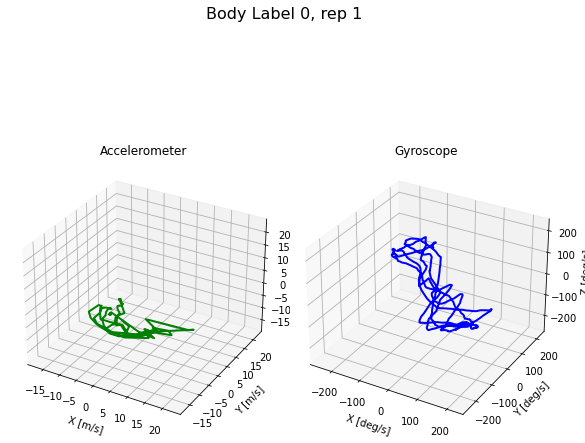

In [16]:
# Assign gif dir and colors to be used
gif_dir = r'C:/Users/dante/Documents/GitHub/pison-tech-assess/WristGifs'
colors = ['green', 'blue']

for bLRepCombo in allbLRep:
    bL  = bLRepCombo[0]
    rep = bLRepCombo[1]

    # Portion out Data
    wristDF = pDF.loc[(pDF['bL'] == bL) & (pDF['rep'] == rep)]
    sensAcc = wristDF[['ax', 'ay', 'az']]
    sensGyr = wristDF[['gx', 'gy', 'gz']]

    # Create matplotlib objects
    fig = plt.figure(facecolor = 'white', figsize=(8, 8))
    fig.suptitle(f'Body Label {bL}, rep {rep}', fontsize=16)

    # Accelerometer Data
    ax = fig.add_subplot(1, 2, 1, projection='3d')

    accData = np.array(sensAcc).T
    x = accData[0]
    y = accData[1]
    z = accData[2]
    numDataPoints = len(z)

    # Accelerometer Line
    lineAcc, = ax.plot(x, y, z, lw=2, c=colors[0])

    ax.set_xlim(accData.min(), accData.max())
    ax.set_ylim(accData.min(), accData.max())
    ax.set_zlim(accData.min(), accData.max())

    ax.set_xlabel('X [m/s]')
    ax.set_ylabel('Y [m/s]')
    ax.set_zlabel('Z [m/s]')
    ax.set_title('Accelerometer')

    # Gyroscope Data
    ax2 = fig.add_subplot(1, 2, 2, projection='3d')

    gyrData = np.array(sensGyr).T
    x = gyrData[0]
    y = gyrData[1]
    z = gyrData[2]
    numDataPoints = len(z)

    # Gyroscope Line
    lineGyr, = ax2.plot(x, y, z, lw=2, c=colors[1])

    ax2.set_xlim(gyrData.min(), gyrData.max())
    ax2.set_ylim(gyrData.min(), gyrData.max())
    ax2.set_zlim(gyrData.min(), gyrData.max())

    ax2.set_xlabel('X [deg/s]')
    ax2.set_ylabel('Y [deg/s]')
    ax2.set_zlabel('Z [deg/s]')
    ax2.set_title('Gyroscope')

    # Make better use of whitespace
    fig.tight_layout()

    # Create animation obj
    ani = FuncAnimation(fig, updateLine, frames=numDataPoints, fargs=(accData, lineAcc, gyrData, lineGyr), 
                        blit=True)
    # HTML(ani.to_jshtml())

    # Save the gif to the folder
    file_dir = os.path.join(gif_dir, f'BL{bL}rep{rep}.gif')
    ani.save(file_dir, writer='Pillow', fps=120)
    if (bL > 0) | (rep > 1):
        plt.close(fig) # Sequestering figure show for ease